**TIØ4317 Empirical Project Report**

**Table of Contents**<br>
0. Necessary python imports<br>
1. Problem statement<br>
2. Data<br>
3. Empirical analysis<br>
4. Conclusion<br>
5. Use of LLMs<br>
6. References

**0. Necessary python imports**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Too many 'soon deprecated' warning, get rid of them
import warnings
warnings.filterwarnings('ignore')

**1. Problem statement**

Can stock market returns and volatility—measured by the S&P 500 index—be predicted using time series data on nonfarm payrolls and the federal funds rate?
This report investigates whether macroeconomic variables such as employment growth and interest rates can serve as predictors of market behavior by capturing the market's implicit expectations of future economic conditions.

Since direct data on market expectations (e.g., futures-implied rate expectations or labor forecasts) is difficult to obtain and quantify, the analysis uses the actual month-over-month changes in nonfarm payrolls and the federal funds rate as proxies for market expectations. This approximation is justified by the relatively short forecast horizon and the tendency of market expectations to track closely with near-term outcomes.

This problem delves into the world of statistical models for time series explanation and forecasting, and tackles both returns and volatility.

**2. Data**

This empirical analysis utilises three datasets:
* S&P 500 index (SP500) - daily, indexed data
* US Federal Funds rate (FEDFUNDS) - monthly, percentage data
* US nonfarm payrolls (PAYEMS) - monthly, absolute data

All datasets are retrieved from the US Federal Reserve Economic Data (FRED) provided by the Federal Reserve Bank of St. Louis

In the following section, the raw datasets will be presented graphically. They will then be transformed through log returns, differencing, and frequency alignment, to ensure stationarity and compatibility for time series modeling. The final processed series will be used in the empirical analysis that follows.

*2.1 SP500 data*

In [1998]:
sp500 = pd.read_csv('SP500.csv', sep=',')
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])
sp500.set_index('observation_date', inplace=True)


In [1999]:
# Preview of data
sp500.head(10)

,SP500
observation_date,
2015-04-13,2092.43
2015-04-14,2095.84
2015-04-15,2106.63
2015-04-16,2104.99
2015-04-17,2081.18
2015-04-20,2100.40
2015-04-21,2097.29
2015-04-22,2107.96
2015-04-23,2112.93


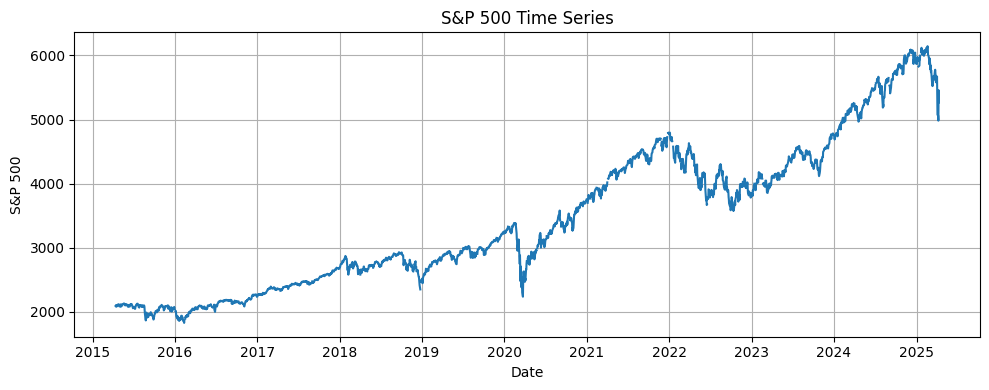

In [2000]:
# Plot of S&P 500 time series
plt.figure(figsize=(10, 4))
plt.plot(sp500.index, sp500['SP500'])
plt.title('S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.2 FEDFUNDS data*

In [2001]:
fedfunds = pd.read_csv('FEDFUNDS.csv', sep=',')
fedfunds['observation_date'] = pd.to_datetime(fedfunds['observation_date'])
fedfunds.set_index('observation_date', inplace=True)

In [2002]:
# Preview of data
fedfunds.head(10)

,FEDFUNDS
observation_date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
1954-12-01,1.28
1955-01-01,1.39
1955-02-01,1.29
1955-03-01,1.35


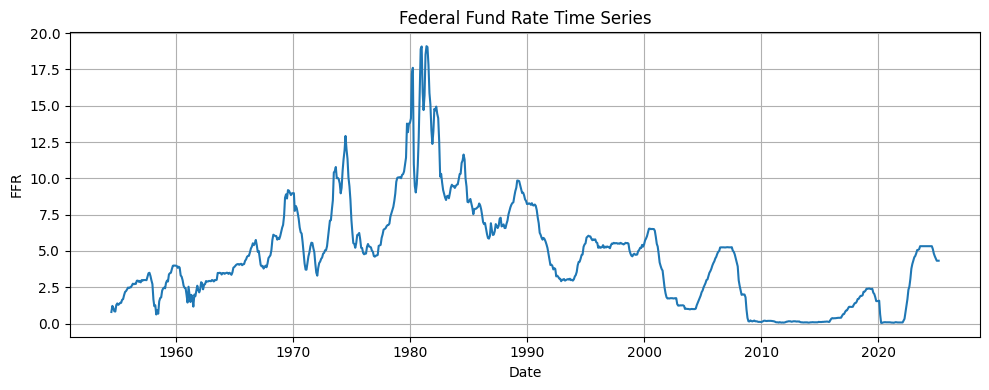

In [2003]:
# Plot of Federal Funds Rate time series
plt.figure(figsize=(10, 4))
plt.plot(fedfunds.index, fedfunds['FEDFUNDS'])
plt.title('Federal Fund Rate Time Series')
plt.xlabel('Date')
plt.ylabel('FFR')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.3 PAYEMS data*

In [2004]:
payems = pd.read_csv('PAYEMS.csv', sep=',')
payems['observation_date'] = pd.to_datetime(payems['observation_date'])
payems.set_index('observation_date', inplace=True)

In [2005]:
# Preview of data
payems.head(10)

,PAYEMS
observation_date,
1939-01-01,29923
1939-02-01,30100
1939-03-01,30280
1939-04-01,30094
1939-05-01,30299
1939-06-01,30502
1939-07-01,30419
1939-08-01,30663
1939-09-01,31031


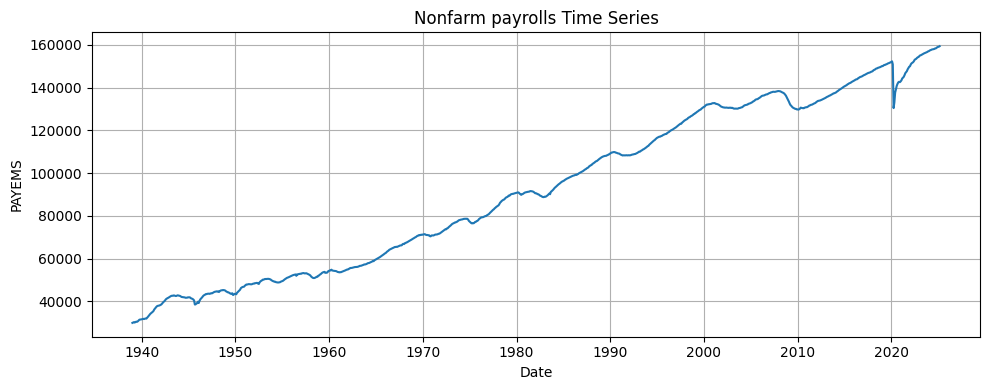

In [2006]:
# Plot of Nonfarm payrolls time series
plt.figure(figsize=(10, 4))
plt.plot(payems.index, payems['PAYEMS'])
plt.title('Nonfarm payrolls Time Series')
plt.xlabel('Date')
plt.ylabel('PAYEMS')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.4 Data cleaning and sampling frequency*

First, we want to ensure that all datasets span over the same time period, that being the period from May 2015 to March 2025

In [2007]:
# Collect first and last timestamps from each dataset
first_record = max(dataset.index.min() for dataset in [sp500, fedfunds, payems])
last_record = min(dataset.index.max() for dataset in [sp500, fedfunds, payems])

print("Common start date:", first_record)
print("Common end date:", last_record)

# Slice all datasets to the common date range
sp500 = sp500.loc[first_record:last_record + pd.Timedelta(days=2)] # Due to trading days
fedfunds = fedfunds.loc[first_record:last_record]
payems = payems.loc[first_record:last_record]

print("SP500 size: ", sp500.size)
print("FEDFUNDS size: ", fedfunds.size)
print("PAYEMS size: ", payems.size)

Common start date: 2015-04-13 00:00:00
Common end date: 2025-03-01 00:00:00
SP500 size:  2581
FEDFUNDS size:  119
PAYEMS size:  119


Although all datasets now cover the same time period, the SP500 dataset has a daily frequency, while FEDFUNDS and PAYEMS are observed monthly. To ensure consistency, the SP500 data is downsampled to a monthly frequency.

An alternative approach would be to upsample the macroeconomic series to a daily frequency, which could theoretically allow for capturing short-term market reactions and better reflect the high-frequency nature of financial markets. However, this method introduces artificial stability in the macro data, as the same value would be repeated across days without incorporating new information. Therefore, downsampling the SP500 offers a more statistically robust and interpretable framework, while still capturing the market’s reaction to monthly macroeconomic changes.

In [ ]:
# Resample SP500 to the first of each month
sp500 = sp500.resample('M').first()

# Re-index all datasets such that information about the date is lost 
# and only information about year and month is retained
sp500.index = sp500.index.to_period('M').to_timestamp()
fedfunds.index = fedfunds.index.to_period('M').to_timestamp()
payems.index = payems.index.to_period('M').to_timestamp()

The nature of the raw data is unfit for statistical modelling as it does not uphold significant assumptions of the ARIMA and GARCH models. Notably, stationarity and homoscedasticity are violated. To capture meaningful cause-and-effect relationships, the data must be appropriately transformed.

SP500:<br>
The S&P 500 index is inherently non-stationary, due to long-term economic growth and inflation. To address this, the data is transformed into log-returns, which helps to (1) stabilize the mean and variance over time, thereby achieving stationarity, and (2) approximate a more normally distributed series — a desirable property for modeling returns and volatility.

PAYEMS:<br>
Like the SP500, the PAYEMS (nonfarm payrolls) series reflects underlying economic and demographic growth, making it non-stationary in levels. Applying a log-difference transformation (i.e., log-returns) to this series ensures stationarity and provides a more interpretable measure of monthly employment growth.

FEDFUNDS:<br>
The Federal Funds Rate is expressed in percentage terms and may appear stationary in levels. However, since this analysis focuses on the market's response to interest rate changes (i.e., monetary policy shocks), the first difference of the FEDFUNDS series is used. This better captures the dynamics between policy shifts and stock market reactions.

In [ ]:
# Transform SP500 data by applying log returns instead of absolute level
sp500: pd.Series = np.log(sp500).diff().dropna()

# Remove the first month of returns (April), as it is unique for the SP500
# and missing in the two other datasets
sp500 = sp500.iloc[1:]

# Log returns for payems instead of absolute level
payems: pd.Series = np.log(payems).diff().dropna()

# First difference of fed funds to capture shocks
fedfunds: pd.Series = fedfunds.diff().dropna().squeeze()

In [ ]:
# Verify that all datasets are of the same size
print("SP500 size: ", sp500.size)
print("FEDFUNDS size: ", fedfunds.size)
print("PAYEMS size: ", payems.size)

SP500 size:  118
FEDFUNDS size:  118
PAYEMS size:  118


*2.5 Plots of all dataset post transformation*

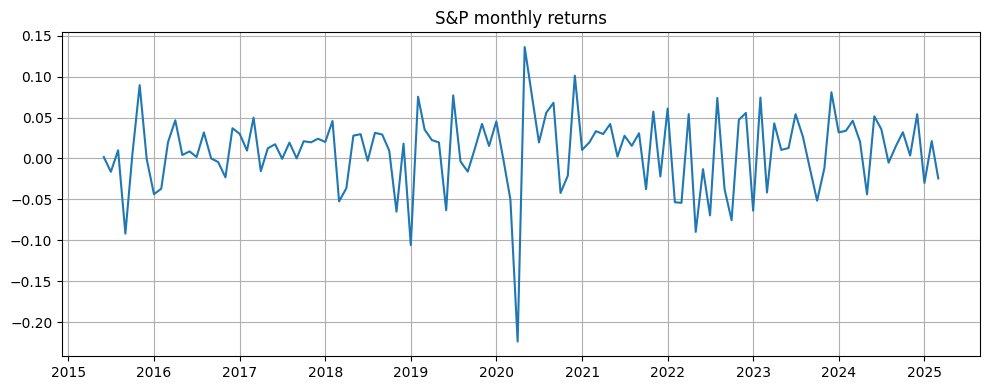

In [ ]:
# SP500 post transformation
plt.figure(figsize=(10, 4))
plt.plot(sp500.index, sp500)
plt.title("S&P monthly log-returns")
plt.grid(True)
plt.tight_layout()
plt.show()

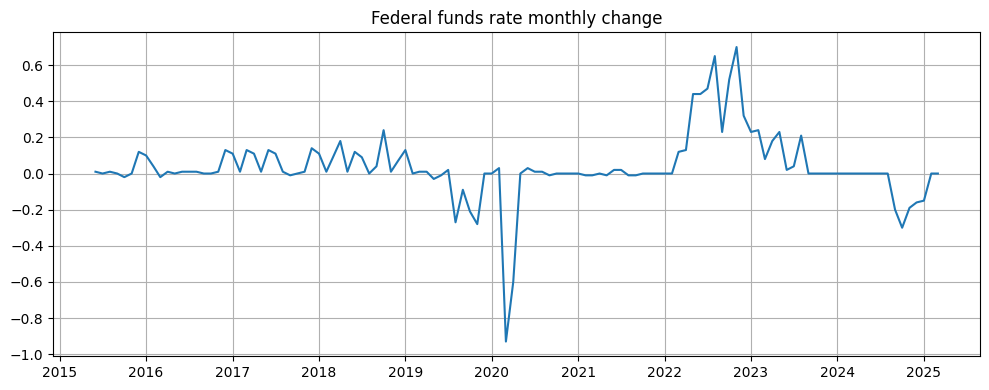

In [ ]:
# FEDFUNDS post transformation
plt.figure(figsize=(10, 4))
plt.plot(fedfunds.index, fedfunds)
plt.title("Federal funds rate monthly change")
plt.grid(True)
plt.tight_layout()
plt.show()

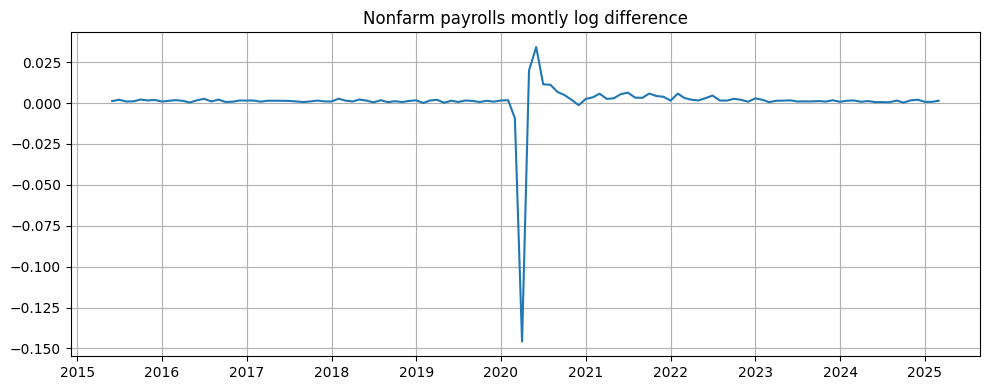

In [ ]:
# PAYEMS post transformation
plt.figure(figsize=(10, 4))
plt.plot(payems.index, payems)
plt.title("Nonfarm payrolls montly log-returns")
plt.grid(True)
plt.tight_layout()
plt.show()

**3. Empirical analysis**

For the empirical analysis, I aim to investigate whether changes in nonfarm payrolls (PAYEMS) and the federal funds rate (FEDFUNDS) influence monthly returns of the S&P 500 index.

To model this relationship, I employ an Autoregressive Integrated Moving Average with Exogenous Variables (ARIMAX) framework. The ARIMAX model is well-suited for this analysis because it allows us to:

1. Capture autocorrelation patterns in the S&P 500 returns over time (via AR and MA terms),

2. Account for potential residual non-stationarity (after log-transformation) through differencing, and

3. Explicitly test the influence of external macroeconomic factors, such as PAYEMS and FEDFUNDS, by incorporating them as exogenous regressors.

This structure enables me to assess not only the time series dynamics inherent in stock market returns but also how they respond to changes in key macroeconomic indicators. Moreover, by using month-over-month changes in PAYEMS and FEDFUNDS as proxies for market expectations, I aim to isolate their impact on financial markets during the same period.

To dig deeper into this analysis, I also estimate a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. Financial return series like the S&P 500 are known to exhibit volatility clustering and time-varying risk, characteristics that violate the assumption of constant variance in classical time series models. The GARCH model addresses this by modeling the conditional variance of returns, allowing me to evaluate how macroeconomic variables influence monthly market volatility. 

*ARIMAX model*

The ARIMAX model extends the classical ARMA model by incorporating exogoneous variables as well as differencing. First, the ARMA(p, q) model can be expressed as:

$\phi(L)y_t=\mu+\theta(L)u_t$

where:<br>
$\phi(L)=1-\phi_1(L^1)-...-\phi_p(L^p)$<br>
are the AR terms, such that $L^i$ is equivalent to $y_(t-i)$

$\theta(L)=1+\theta_1(L^1)+...+\theta_q(L^q)$<br>
are the MA terms, such that $L^i$ is equivalent to $y_(t-i)$

$\mu$ is the drift of the model

$u_t~N(1, \sigma^2)$<br>
is a white noise term, normally distributed with a mean of 0 and variance $\sigma^2$

The ARIMAX(p, d, q) builds on the ARMA by adding:

$\phi(L)(1-L)^d*y_t=\mu+\theta(L)u_t+\beta*X_t$

where:<br>
$d$ is the degree of differencing required to achieve stationarity

$X_t$ are the exogenous variables, with the corresponding coefficients $\beta$

Explaining the model components one by one: 

1. Autoregressive (AR) part ($\phi(L)y_t$):<br>
Captures the relationship between the current value and its previous lags. Useful for modeling momentum or memory in the data.

2. Differencing (I) part ($(1-L)^d$):<br>
Removes non-stationarity in the series by computing changes (first differences, second differences, etc.).

3. Moving Average (MA) part ($\theta(L)u_t$):<br>
Captures the influence of past forecast errors (shocks) on the current value.

4. Exogenous variables (x) part ($\beta*X_t$):<br>
These are external predictors not generated by the endogenous process. In ARIMAX, this term allows for testing the direct effect of outside influences (e.g., macroeconomic variables) on the target variable.

First, we build a first-pass ARIMAX model:

In [2016]:

exog = pd.concat([payems, fedfunds], axis=1)
exog.columns = ["PAYEMS", "FEDFUNDS"]

model = SARIMAX(endog=sp500, exog=exog, order=(1, 1, 1))

results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                  118
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 207.059
Date:                Sat, 12 Apr 2025   AIC                           -404.118
Time:                        22:52:40   BIC                           -390.307
Sample:                    06-01-2015   HQIC                          -398.511
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PAYEMS         1.7939      0.939      1.911      0.056      -0.046       3.634
FEDFUNDS      -0.0276      0.016     -1.719      0.086      -0.059       0.004
ar.L1         -0.2184      0.092     -2.383      0.0

We can see that the first-pass ARIMAX model using a (1, 1, 1) order indicates that there is a relationship between the markets expectations to changes in nonfarm payrolls statistics and federal funds rate changes as represented by the actual changes.<br>
PAYEMS are indicated to 
The relationship is, however, just not statistically significant as PAYEMS has a

Then we build on the model to find the best p, d and q parameters according to the information criterion:

In [2017]:
aic_scores = dict()
bic_scores = dict()
models = dict()

for p in range(3):
    for d in range(3):
        for q in range(3):
            model = SARIMAX(endog=sp500, exog=exog, order=(p, d, q))

            results = model.fit()

            aic_scores[f'({p}, {d}, {q})'] = results.aic
            bic_scores[f'({p}, {d}, {q})'] = results.bic
            models[f'({p}, {d}, {q})'] = results

# Find the best (lowest) AIC and BIC orders
best_aic_order = min(aic_scores, key=aic_scores.get)
best_bic_order = min(bic_scores, key=bic_scores.get)

print(f'Best AIC order: {best_aic_order} with AIC = {aic_scores[best_aic_order]:.2f}')
print(f'Best BIC order: {best_bic_order} with BIC = {bic_scores[best_bic_order]:.2f}')

Best AIC order: (2, 0, 2) with AIC = -414.04
Best BIC order: (0, 0, 0) with BIC = -399.81


We can thus see that the best model according to the Akaike Information Criterion is the model with two AR terms and 2 MA terms, and no differencing, however the Bayesian Information Criterion (BIC) indicates that the best model is just a simple model with no AR, differencing or MA terms.<br>

The AIC is given by:<br>
$
\mathrm{AIC} = \ln(\hat{\sigma}^2) + \frac{2k}{T}
$
<br> Where $\ln(\hat{\sigma}^2)$ is the sample variance, $k$ is the sum of the AR and MA terms plus 1 and $T$ is the sample size.<br>
In general, AIC penalizes complexity of the model somewhat, but not as hard as BIC. As such, the more complex model was deemed better by AIC.

The BIC is given by:<br>
$
\mathrm{BIC} = \ln(\hat{\sigma}^2) + \frac{k}{T}*\ln(T)
$
<br> Where $\ln(\hat{\sigma}^2)$ is the sample variance, $k$ is the sum of the AR and MA terms plus 1 and $T$ is the sample size.<br>
BIC penalizes complexity more heavily than AIC, and as such the improved fit of the extra AR and MA terms did not justify the increased complexity under the BIC.<br><br>

As we want higher prediction accuracy, we will go with the ARIMAX(2, 0, 2) model as suggested by the AIC.

*GARCH model*

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is a framework for modeling and forecasting time-varying volatility in financial time series. Introduced by Bollerslev (1986) as an extension of Engle’s (1982) ARCH model, GARCH is specifically designed to capture volatility clustering — the empirical observation that large changes in asset returns tend to be followed by further large changes (of either sign), while small changes tend to be followed by small ones.

To estimate PAYEMS and FEDFUNDS impact on SP500 volatility, I have employed a GARCH(1, 1) model, using 1 lag term for recent return, 1 lag term for recent volatility, a constant mean and a normal distribution for the stochastic element.

In [2028]:
garch_model = arch_model(
    y=sp500,
    x=exog,
    vol='GARCH',
    p=1, q=1,
    mean='LS',
    dist='normal'
)

results = garch_model.fit(disp='off')

print(results.summary())

                     Least Squares - GARCH Model Results                      
Dep. Variable:                  SP500   R-squared:                       0.246
Mean Model:             Least Squares   Adj. R-squared:                  0.233
Vol Model:                      GARCH   Log-Likelihood:                211.556
Distribution:                  Normal   AIC:                          -411.112
Method:            Maximum Likelihood   BIC:                          -394.488
                                        No. Observations:                  118
Date:                Sat, Apr 12 2025   Df Residuals:                      115
Time:                        23:05:30   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      8.0089e-03  3.082e-03      2.598  9.370e-03 

As one can see from the GARCH(1, 1) output, there is an implied effect of both FEDFUNDS and PAYEMS on the SP500, however only the PAYEMS is statistically significant.<br>
A 1% increase in PAYEMS contributes to a 1.93% increase in the SP500, all else alike. This effect is highly probable, as the p-value stands at < 0.0001.<br>
A 1% increase in the FEDFUNDS, however, has a slight negative effect on SP500, however this effect is far from statistically significant, and as such we cannot conclude with anything as of now.<br><br>

We also see that past shocks influence current volatility, as indicated by the $\omega$, $\alpha$ and $\beta$ parameters.<br>
$\omega$ is the base volatility, at 0.00037.<br>
$\alpha$ is the effect of previous shocks, at 0.1960.<br>
$\beta$ is the effect of previous volatility, at 0.5914.<br>

Since $\alpha + \beta < 1 $, volatility is stationary, which makes intuitive sense, as shocks should not be overly persistent.

As such, the model indicates that PAYEMS and past volatility are the most influential factors for determining future volatility.

*GARCH(1, 1) conditional volatility of SP500*

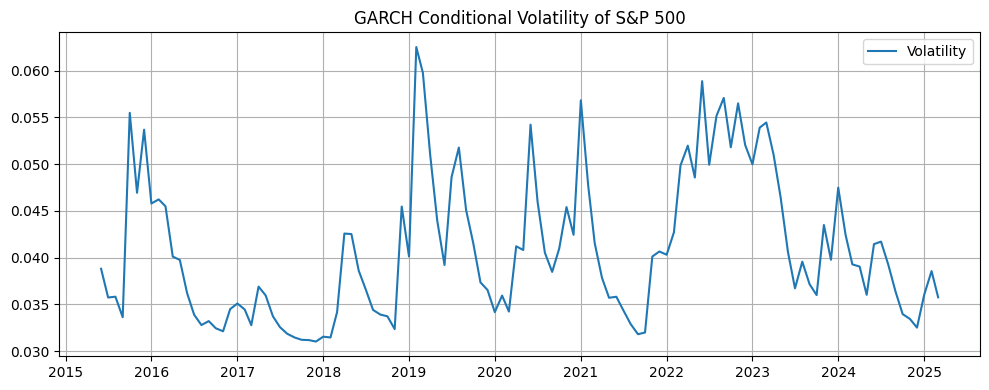

In [2029]:
plt.figure(figsize=(10, 4))
plt.plot(results.conditional_volatility, label='Volatility')
plt.title("GARCH Conditional Volatility of S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

*Model evaluation*

In [2030]:
# Mean squared error

In [2031]:
# Root mean squared error

In [2032]:
# Mean absolute percentage error

**Conclusion**

XX

**Use of LLMs**

I have used LLMs throughout the report to explain me complex topics and debug my code, as I find that both can be very time-consuming activities, and as such I see that my work has become much more efficient by utilising LLMs such as ChatGPT.<br>
I find that using LLMs for university assignments can be a two-sided sword, as it can both empower the user to focus on the more important tasks at hand, and also give the user a way around actually learning and implementing the tasks.<br>
Therefore, I have tried to contain LLM usage to the tasks that provide me the lowest marginal benefit compared to the time I spend on them. <br>

**References**

- Bollerslev, T. (1986). *Generalized Autoregressive Conditional Heteroskedasticity*. Journal of Econometrics.
- Engle, R. F. (1982). *Autoregressive Conditional Heteroskedasticity with Estimates of the Variance of UK Inflation*. Econometrica.
